# __Monoexponential fitting of gradient echo signal decay using ARLO notebook__
#### __Last updated on:__ 15/03/2022
#### __Author:__ Rakshit Dadarwal

Reference paper:
* title = An Algorithm for Fast Mono-exponential Fitting Based on Auto-Regression on Linear Operations (ARLO) of Data 
* url = https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4175304/ 
* doi = 10.1002/mrm.25137

### __Import libraries__

In [10]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### __Load multi-echo gradient ehco (GRE) MRI data__

In [5]:
# data path
src_path = "/home/rdadarwal/Pig/test_data/"
os.chdir(src_path)
# read GRE data
gre_img = nib.load('GRE_4D.nii.gz')
a,b,c,nte = gre_img.shape
gre = gre_img.get_fdata()
# read echo times
te = (pd.read_csv('TEs.txt', sep="\t", header=None)).values
te = te[0]

### __Monoexponential fitting__

In [6]:
# R2* estimation
def r2s(gre, te):
    yy = np.zeros((a,b,c))
    yx = np.zeros((a,b,c))
    beta_yx = np.zeros((a,b,c))          
    beta_xx = np.zeros((a,b,c))
    s1=[]; d1=[]
    for j in range(nte-2):
        alpha = (te[j+2]-te[j])*(te[j+2]-te[j])/2/(te[j+1]-te[j])
        tmp = (2*te[j+2]*te[j+2] - te[j]*te[j+2] - te[j]*te[j] + 3*te[j]*te[j+1] -3*te[j+1]*te[j+2])/6
        beta = tmp/(te[j+2]-te[j+1]) 
        gamma = tmp/(te[j+1]-te[j])

        y1 = gre[:,:,:,j]*(te[j+2]-te[j]-alpha+gamma)+gre[:,:,:,j+1]*(alpha-beta-gamma)+gre[:,:,:,j+2]*beta
        x1 = gre[:,:,:,j]-gre[:,:,:,j+2]

        yy = yy+y1*y1
        yx = yx+y1*x1
        beta_yx = beta_yx + beta*y1*x1
        beta_xx = beta_xx + beta*x1*x1

    r2 = (yx + beta_xx)/(beta_yx + yy)
    r2[np.isnan(r2)] = 0
    r2[np.isinf(r2)] = 0

    return r2

In [7]:
# R2* map
r2star = r2s(gre, te)      
# save
nib.save(nib.Nifti1Image(r2star, gre_img.affine), 'R2star.nii.gz')

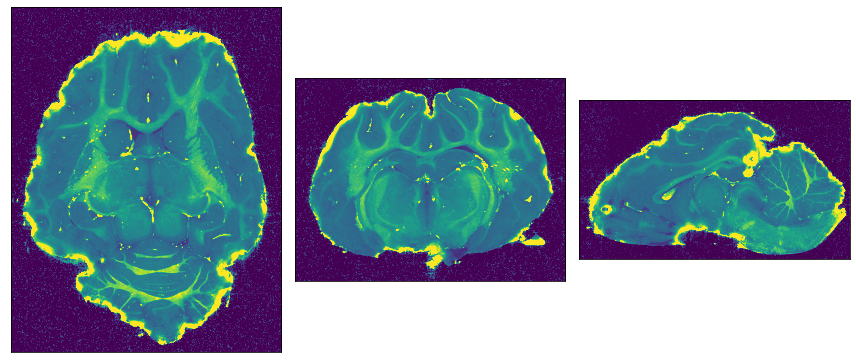

In [30]:
# Plot
fig, [ax0, ax1, ax2] = plt.subplots(1,3,figsize=(12,8),subplot_kw={'xticks': [], 'yticks': []})
ax0.imshow(r2star[:,:,160].T, vmin=10, vmax=80)
ax1.imshow(np.rot90(r2star[:,276,:],k=3), vmin=10, vmax=80)
ax2.imshow(r2star[216,:,:].T, vmin=10, vmax=80)
plt.tight_layout()